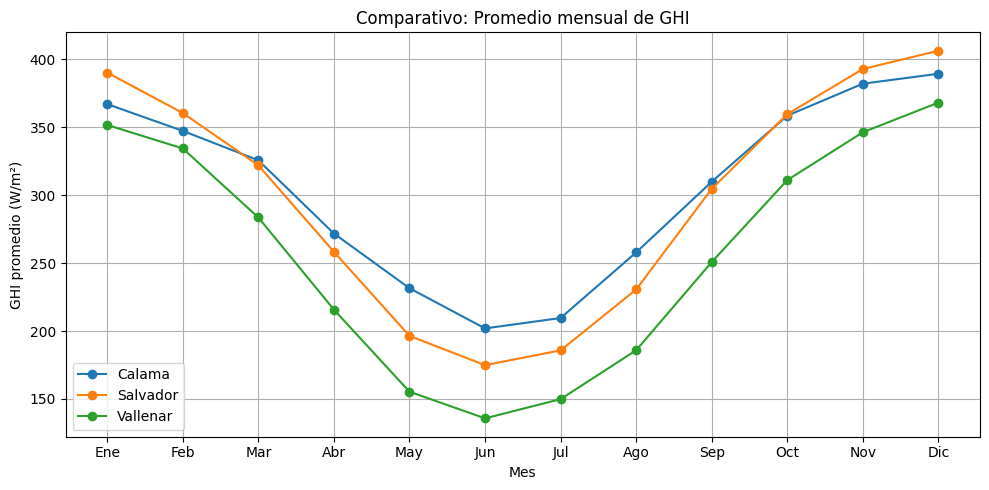

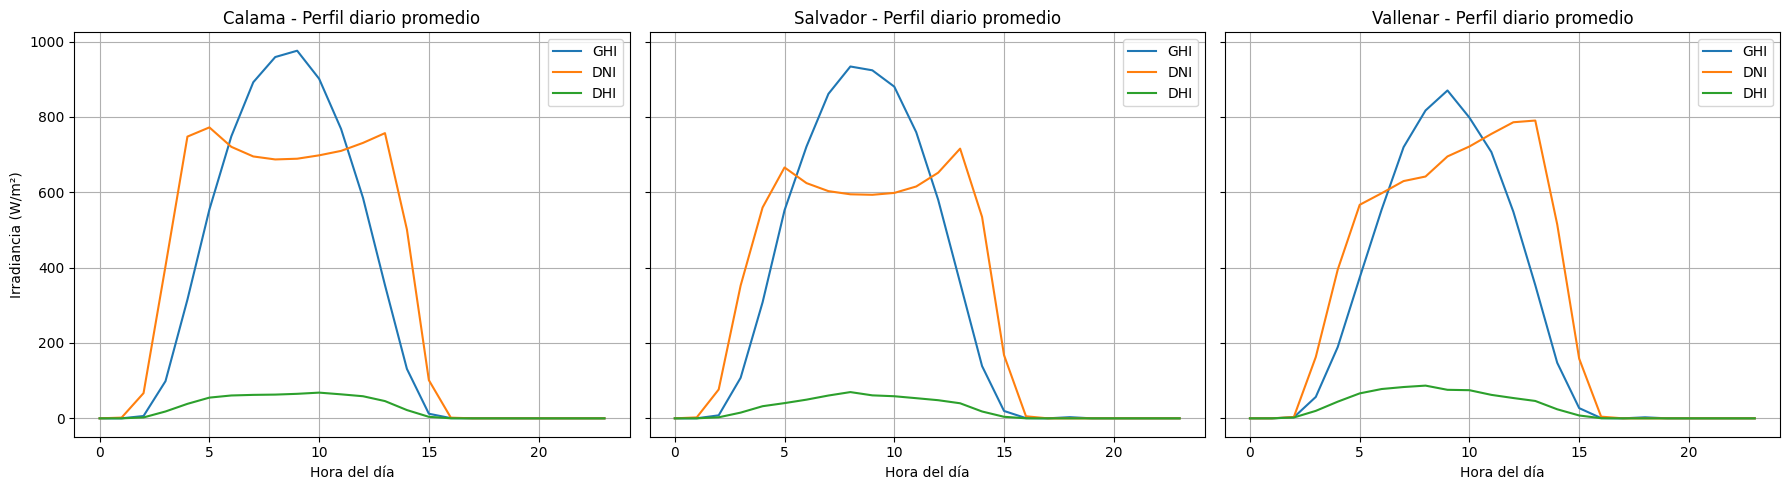

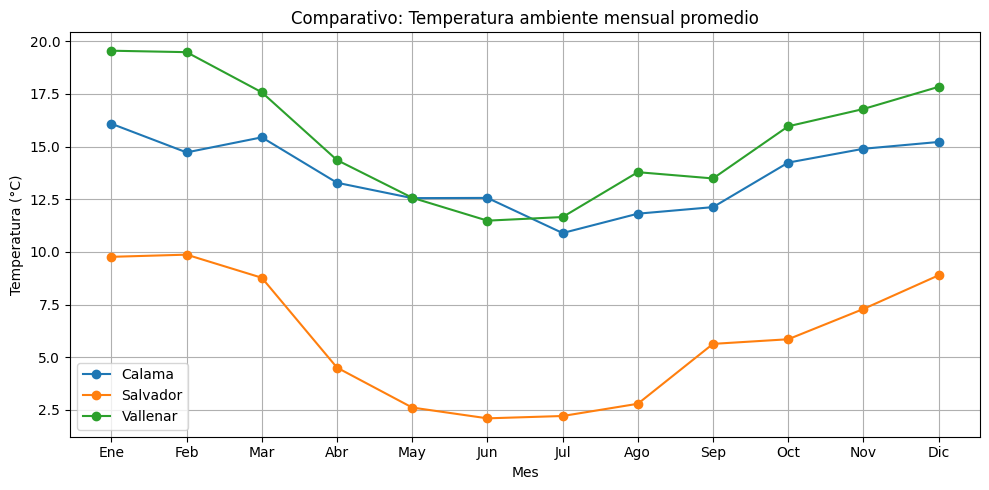

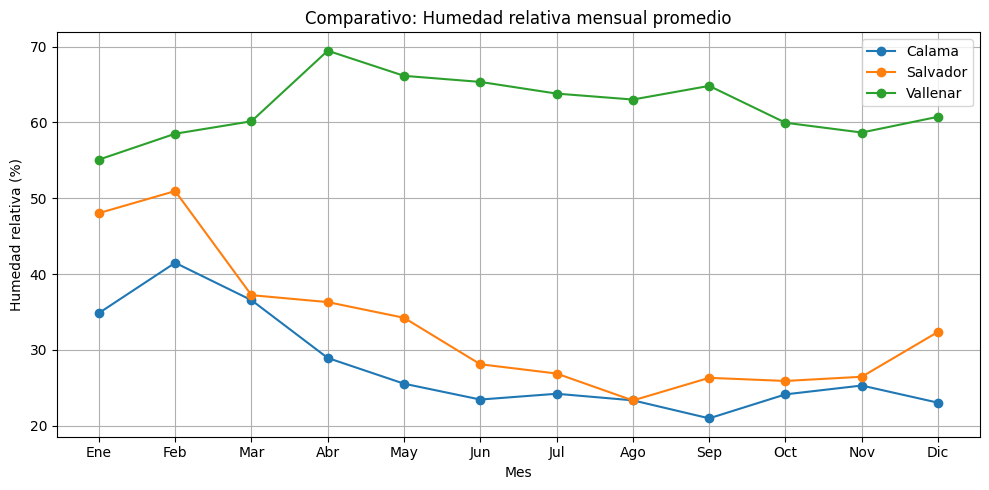

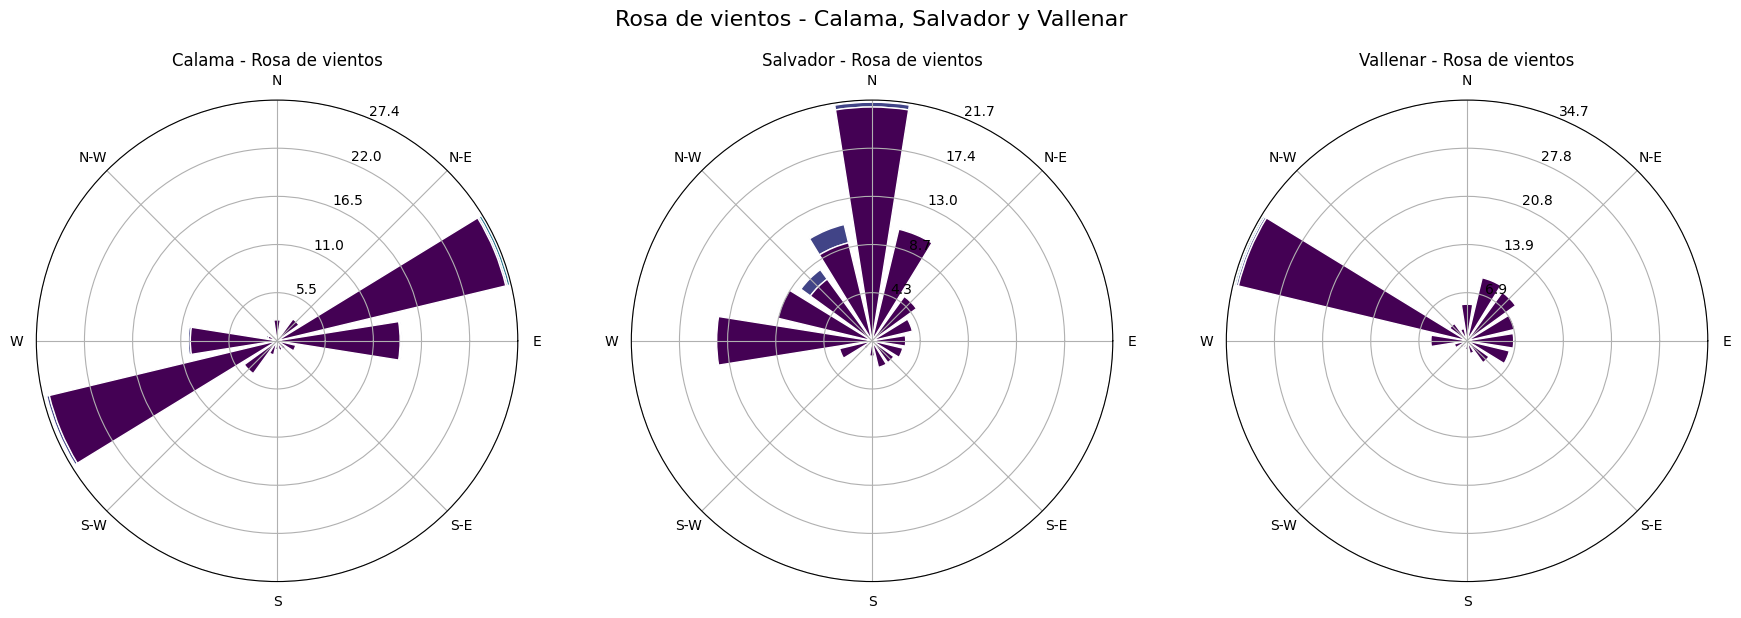

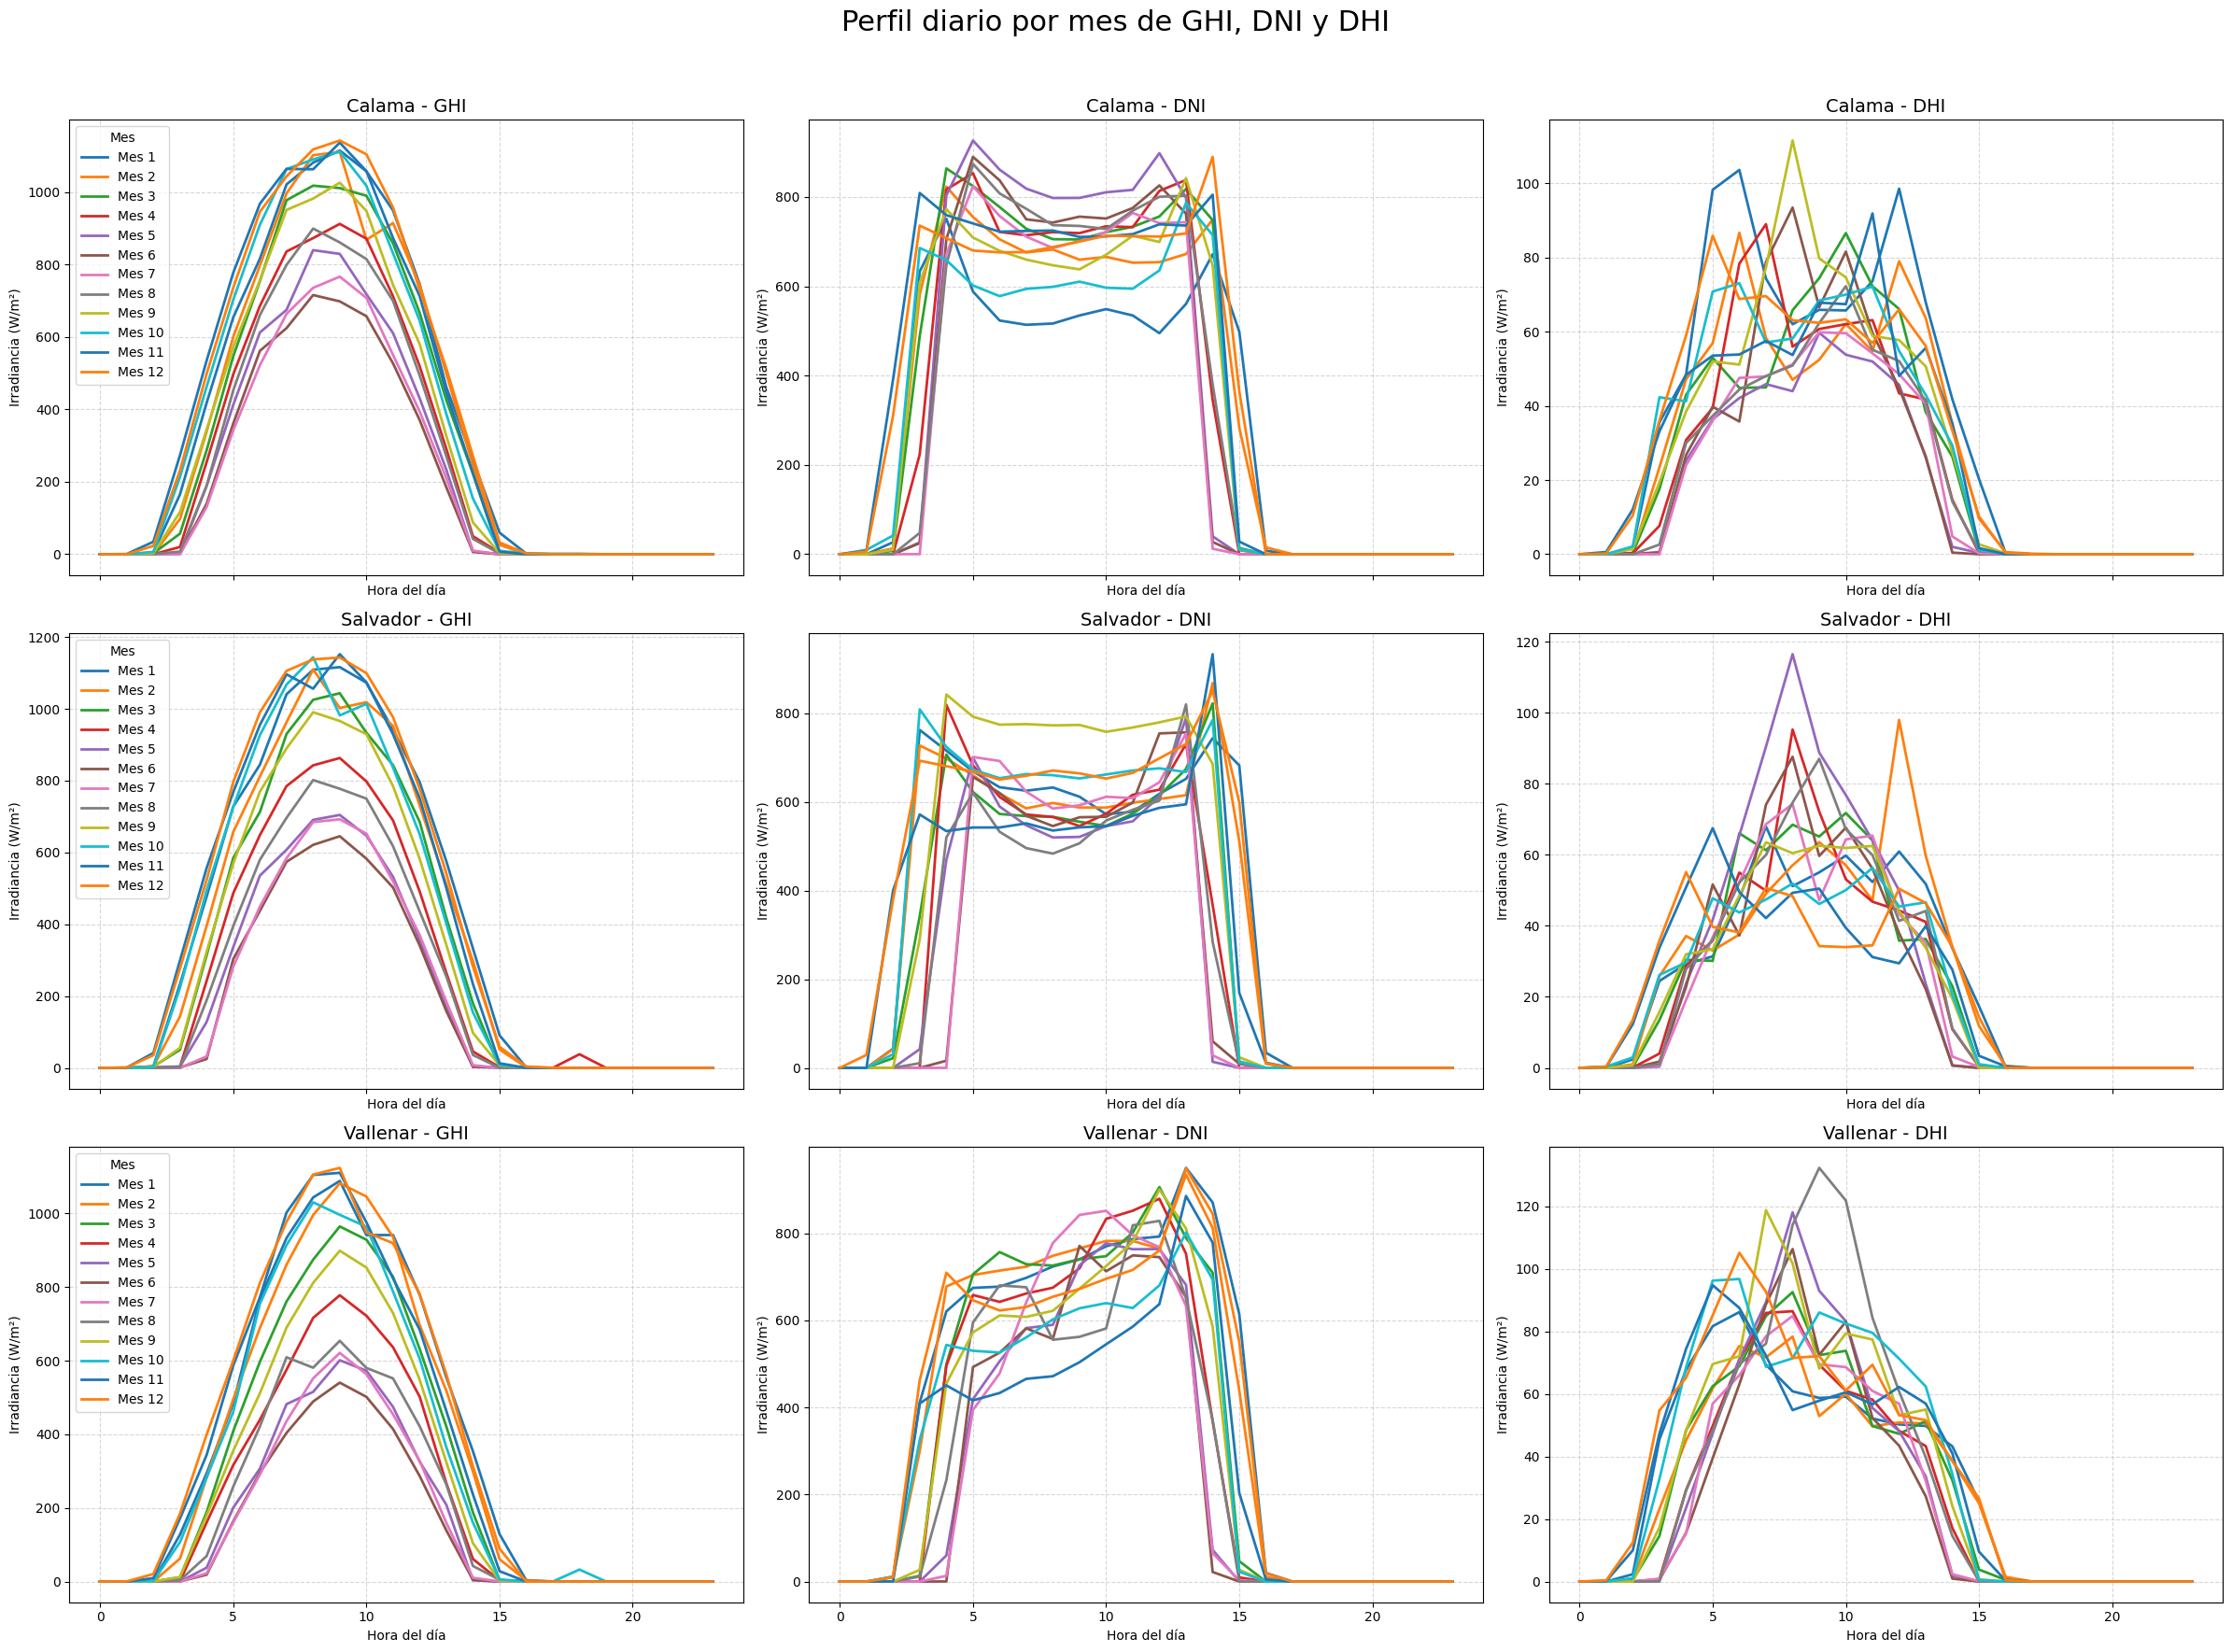

In [6]:
"""
Análisis comparativo de datos meteorológicos para sitios solares en Chile:
Calama, El Salvador y Vallenar.

Este script carga archivos TMY limpios y realiza:
1. Comparación de irradiancia diaria y mensual.
2. Análisis mensual de temperatura y humedad relativa.
3. Visualización conjunta de rosas de viento.
4. Análisis individuales (correlación temperatura–GHI).
5. Perfiles diarios por mes de GHI, DNI y DHI para cada sitio.

Todos los gráficos se muestran y algunos se guardan como archivos PNG.
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from windrose import WindroseAxes

# === Definición de archivos de entrada por sitio ===
files = {
    "Calama": "calama_clean.csv",
    "Salvador": "salvador_clean.csv",
    "Vallenar": "Vallenar_clean.csv"
}
utc_offset = -4  # Offset horario para Chile (invierno)

# === Carga y preprocesamiento de archivos ===
dfs = {}
for name, path in files.items():
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']], errors='coerce')
    df['datetime_local'] = df['datetime'] + pd.to_timedelta(utc_offset, unit='h')
    df.set_index('datetime_local', inplace=True)
    dfs[name] = df

# === 1. Comparativo mensual de GHI promedio por sitio ===
plt.figure(figsize=(10, 5))
for name, df in dfs.items():
    monthly_ghi = df.groupby('Month')['GHI'].mean()
    plt.plot(range(1, 13), monthly_ghi, marker='o', label=name)
plt.title("Comparativo: Promedio mensual de GHI")
plt.xlabel("Mes")
plt.ylabel("GHI promedio (W/m²)")
plt.xticks(ticks=np.arange(1, 13), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Perfil diario promedio de irradiancia (GHI, DNI, DHI) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (name, df) in zip(axes, dfs.items()):
    for col in ['GHI', 'DNI', 'DHI']:
        ax.plot(df.groupby(df.index.hour)[col].mean(), label=col)
    ax.set_title(f"{name} - Perfil diario promedio")
    ax.set_xlabel("Hora del día")
    ax.grid(True)
    if ax is axes[0]:
        ax.set_ylabel("Irradiancia (W/m²)")
    ax.legend()
plt.tight_layout()
plt.show()

# === 3. Comparativo mensual de temperatura ambiente ===
plt.figure(figsize=(10, 5))
for name, df in dfs.items():
    monthly_temp = df.groupby('Month')['Tdry'].mean()
    plt.plot(range(1, 13), monthly_temp, marker='o', label=name)
plt.title("Comparativo: Temperatura ambiente mensual promedio")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(ticks=np.arange(1, 13), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 4. Comparativo mensual de humedad relativa ===
plt.figure(figsize=(10, 5))
for name, df in dfs.items():
    monthly_rh = df.groupby('Month')['RH'].mean()
    plt.plot(range(1, 13), monthly_rh, marker='o', label=name)
plt.title("Comparativo: Humedad relativa mensual promedio")
plt.xlabel("Mes")
plt.ylabel("Humedad relativa (%)")
plt.xticks(ticks=np.arange(1, 13), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Rosa de vientos comparativa (3 subgráficos en una sola imagen) ===
fig = plt.figure(figsize=(18, 6))
nombres = list(dfs.keys())

for i, name in enumerate(nombres):
    df = dfs[name]
    wind_dir = df['Wdir'].fillna(0)
    wind_speed = df['Wspd'].fillna(0)

    ax = fig.add_subplot(1, 3, i + 1, projection='windrose')
    ax.bar(wind_dir, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'{name} - Rosa de vientos')

fig.suptitle("Rosa de vientos - Calama, Salvador y Vallenar", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("rosa_vientos_comparativa.png", dpi=300)
plt.show()


# === 6. Perfil diario por mes - GHI, DNI, DHI en cada localidad ===
variables = ['GHI', 'DNI', 'DHI']
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 18), sharex=True)
fig.suptitle("Perfil diario por mes de GHI, DNI y DHI", fontsize=22, y=0.98)
plt.subplots_adjust(hspace=0.3, wspace=0.15)

for row_idx, (site, df) in enumerate(dfs.items()):
    df = df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    for col_idx, var in enumerate(variables):
        ax = axes[row_idx, col_idx]
        for mes in range(1, 13):
            sub_df = df[df['month'] == mes]
            perfil = sub_df.groupby('hour')[var].mean()
            ax.plot(perfil.index, perfil.values, label=f'Mes {mes}', lw=2)
        ax.set_title(f"{site} - {var}", fontsize=14)
        ax.set_xlabel('Hora del día')
        ax.set_ylabel('Irradiancia (W/m²)')
        ax.grid(True, linestyle='--', alpha=0.5)
        if col_idx == 0:
            ax.legend(title='Mes', loc='upper left', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('perfiles_diarios_por_mes_tres_sitios.png', dpi=300)
plt.show()
